# WATER BAG TIME SERIE CLASSIFICATION - Preliminar Evaluation

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [22]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Group related split, evaluation and probability methods (Authoral)
from Modulos.imbalanced_selection import (
    groupConsecutiveFlags, MinorityGroupSplitUndersample,
    group_metrics, scoring, cross_val_predict_proba
)
from Modulos.probability import (
    predict_proba, scale_proba, clf_score, precision_recall_plot,
    groups_windows, window_prob, multi_window_prob
)

#### Preprocessing & machine learning modules
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import all_estimators
classifiers = dict(all_estimators('classifier'))

## Utility Funcitons

In [8]:
# None

---
## Load & Preprocess Data

#### Load

In [12]:
from Modulos.waterbags import waterbag_project, custom_preprocessing, select_target

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True, time_features=True)

data = project.data
Yi = project.time_serie
waterbags = project.waterbags

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO\Modulos\waterbags.py:63: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  upsample = inmet.resample('15Min').pad()


#### Preprocess

In [13]:
# Sample groups names per group label
target_names = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

# Drop specific columns from trining dataset
out_time = ['index', 'year', 'date']
out_stations = ['A652', 'A654']
out_inmet = [col for col in data if np.any([station in col for station in out_stations])]

out_cols = out_time + out_inmet
data.drop(out_cols, axis=1, inplace=True)

print('Dataset shape:', data.shape); print()
print('Excluded columns:', out_cols); print()

Dataset shape: (437875, 213)

Excluded columns: ['index', 'year', 'date', 'acumulado_chuva_1_h - A652', 'pressao_minima - A652', 'temperatura - A652', 'pressao_maxima - A652', 'pressao - A652', 'velocidade_vento - A652', 'temperatura_orvalho_maximo - A652', 'temperatura_minima - A652', 'temperatura_orvalho_minimo - A652', 'temperatura_orvalho - A652', 'rajada_vento_max - A652', 'temperatura_maxima - A652', 'radiacao_global - A652', 'acumulado_chuva_1_h - A654', 'pressao_minima - A654', 'temperatura - A654', 'pressao_maxima - A654', 'pressao - A654', 'velocidade_vento - A654', 'temperatura_orvalho_maximo - A654', 'temperatura_minima - A654', 'temperatura_orvalho_minimo - A654', 'temperatura_orvalho - A654', 'rajada_vento_max - A654', 'temperatura_maxima - A654', 'radiacao_global - A654']



---
# 1. Preprocessing & Data Transformation

## Preprocessing

In [14]:
label_cols = data.columns[:9]

transform_args = dict(
    label_encode=label_cols,
    interpolate='nearest', fillna='mean'
)

data_encoded, encoder = custom_preprocessing(data.copy(), **transform_args)

Initial shape: (437875, 213)
Label columns encoded: ['month', 'day', 'hour', 'minute', 'time', 'dayofyear', 'weekofyear', 'weekday', 'quarter']
Interpolation: nearest
Fill missing values: mean


### Target rolling proportion

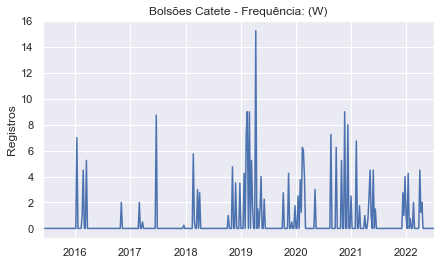

In [15]:
target_id = '1'
periods_ahead = 4

window = 'W'
ax = (Yi.loc['2015-06': , target_id].resample(window).sum() / 4).plot(
    title=f'Bolsões Catete - Frequência: ({int(window / 24 / 4) if type(window) is int else window})',
    figsize=(7, 4)
); ax.set(ylabel='Registros'); plt.show()

### Feature set

In [507]:
n_splits = 3
train_start, train_end = '2018-07', '2020-06'
eval_start, eval_end = '2020-07', '2022-04'

X = data_encoded[train_start: eval_end].copy()

# Validation split
xt = X[train_start: train_end]
xe = X[eval_start: eval_end]

non_constant = X.columns[[len(X[col].unique()) != 1 for col in X.columns]]

### Target variable

In [614]:
Y, groups, y_cnt = select_target(Yi, X, target_id, periods_ahead, shift=0, names=target_names)

Y_true =  Yi[str(target_id)].loc[X.index].copy()
groups_true = groupConsecutiveFlags(Y_true)

# Target validation split
yt = Y.loc[xt.index]
ye = Y.loc[xe.index]
groups_train = groups.loc[xt.index]
groups_eval = groups.loc[xe.index]

eval_p = (ye.value_counts() / Y.value_counts() * 100)
print(); display(eval_p.round(2).to_frame('Validation (%)'))

Selected Target: Rua do Catete - id: 1 

Target range: 4
Target shift: 4



,Validation (%)
0.0,47.81
1.0,44.53


---
# 3. Simple split pipeline evaluation

In [615]:
seed = 0

### Base model

In [616]:
import sklearn.neural_network as nn

mlp = nn.MLPClassifier

model = mlp(
    (100,), verbose=1, random_state=seed, batch_size=200,
    early_stopping=True, validation_fraction=0.1,
    n_iter_no_change=5, tol=0.0012, max_iter=50,
)

sgd = classifiers['SGDClassifier']
# model = sgd(loss='log', penalty='l1', alpha=0.0001, l1_ratio=0.15, random_state=0, n_jobs=-1, max_iter=1000, verbose=1, tol=0.01)

### Fit and predict with model pipeline

In [617]:
train_prct = 0.0125
rus = RandomUnderSampler(sampling_strategy=train_prct, random_state=seed)
column_trans = ColumnTransformer([('scale', mms(), non_constant)], remainder='drop')

# Pipeline
pipe = Pipeline([('scale', column_trans), ('under', rus), ('model', model)])

# Fit pipeline
pipe.fit(xt, yt)

# Predict Probability
yprob = predict_proba(pipe, xe)
# yprob = scale_proba(yprob, 0.5, limit=None)

Iteration 1, loss = 0.04784153
Validation score: 0.991071
Iteration 2, loss = 0.02096308
Validation score: 0.993080
Iteration 3, loss = 0.01734666
Validation score: 0.993750
Iteration 4, loss = 0.01596848
Validation score: 0.993973
Iteration 5, loss = 0.01405182
Validation score: 0.994196
Iteration 6, loss = 0.01298400
Validation score: 0.995089
Iteration 7, loss = 0.01206893
Validation score: 0.994420
Iteration 8, loss = 0.01107372
Validation score: 0.995536
Validation score did not improve more than tol=0.001200 for 5 consecutive epochs. Stopping.
predict_proba method used.


### Prediction evaluation

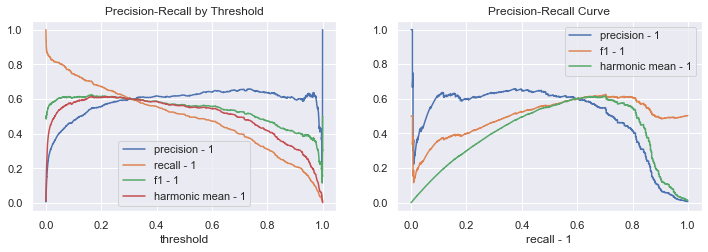

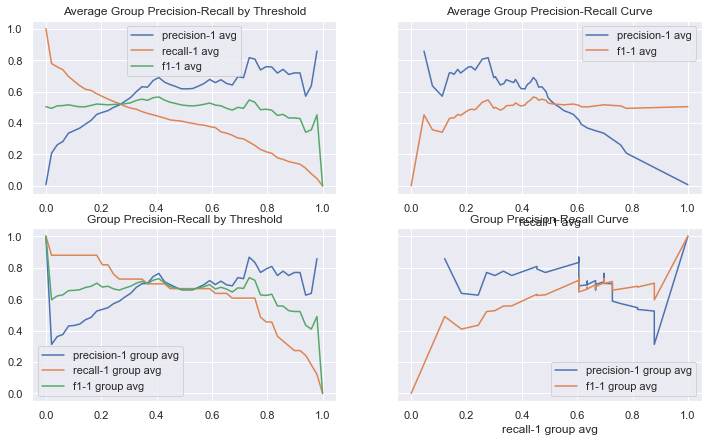

,precision,recall,f1-score,support
0.0,0.996602,0.997836,0.997219,63780.000000
1.0,0.621918,0.511261,0.561187,444.000000
accuracy,0.994472,0.994472,0.994472,0.994472
macro avg,0.809260,0.754549,0.779203,64224.000000
weighted avg,0.994012,0.994472,0.994204,64224.000000


Target groups: 33 



recall-1          0.410561
recall-1 group    0.666667
dtype: float64


Prediction groups: 41 



precision-1          0.617314
precision-1 group    0.658537
dtype: float64

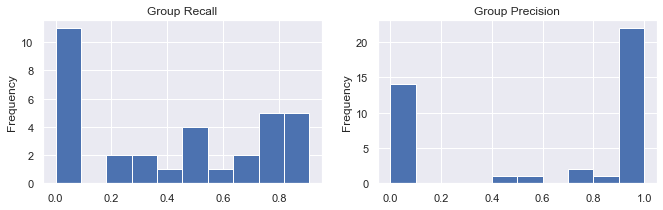

In [618]:
### Evaluate prediction
ax = precision_recall_plot(ye, yprob)
ax, grp_curve = group_metrics.group_precision_recall_plot(ye, yprob, groups_eval, num=50)

### Selected threshold
sel_thresh = 0.5
yhat = (yprob > sel_thresh).astype('int')
groups_hat = groupConsecutiveFlags(ts=yhat)

scr = clf_score(ye, yprob, sel_thresh)
plt.show(); display(scr)
ax = group_metrics.group_precision_recall_stats(ye, yhat, groups_eval, groups_hat)

# Feature Selection

### Time series based split

In [619]:
# n_splits = 3

splitter = TimeSeriesSplit(n_splits, max_train_size=None, test_size=None)
cv_time = list(splitter.split(X, Y))

# Fill test folders
for i in range(n_splits):
    cv_time[i] = (cv_time[i][0], np.arange(cv_time[i][1].min(), len(X)))

### Sequential Feature Selection

In [ ]:
from sklearn.feature_selection import RFE, SequentialFeatureSelector as SFS

model.set_params(verbose=1)

selector = SFS(
    model,
    n_features_to_select=len(X.columns) - 3,
    direction='backward',
    scoring=scoring['f1'],
    cv=cv_time,
    n_jobs=-1,
)

selector.fit(X, Y)
selected_columns = X.columns[selector.support_]

print('Selected Features:', f'{len(selected_columns)}/{xt.shape[1]}')

### Feature importance with permutation score

Obs: Testar seleção de features com cross-validação

In [620]:
from sklearn.inspection import permutation_importance

r = permutation_importance(pipe, xe, ye, n_repeats=5,
                           scoring=scoring['f1-1'],
                           random_state=None, n_jobs=-1)

fi = pd.Series(r['importances_mean'], index=xt.columns).sort_values(ascending=False)
selected_columns = fi.index[fi > 0]

print('Selected Features:', f'{len(selected_columns)}/{xt.shape[1]}')

Selected Features: 148/213


### Refit and evaluate pipeline

Iteration 1, loss = 0.06122813
Validation score: 0.993304
Iteration 2, loss = 0.02134636
Validation score: 0.992634
Iteration 3, loss = 0.01847945
Validation score: 0.992857
Iteration 4, loss = 0.01708689
Validation score: 0.994196
Iteration 5, loss = 0.01617717
Validation score: 0.993527
Iteration 6, loss = 0.01526422
Validation score: 0.994643
Iteration 7, loss = 0.01499702
Validation score: 0.995089
Validation score did not improve more than tol=0.001200 for 5 consecutive epochs. Stopping.
predict_proba method used.


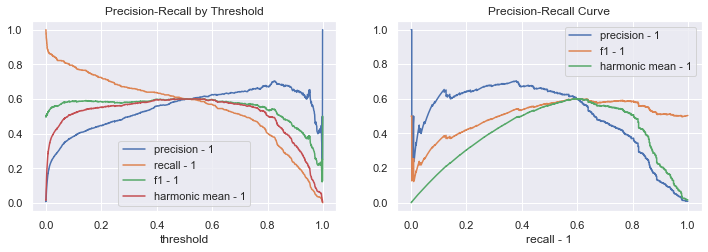

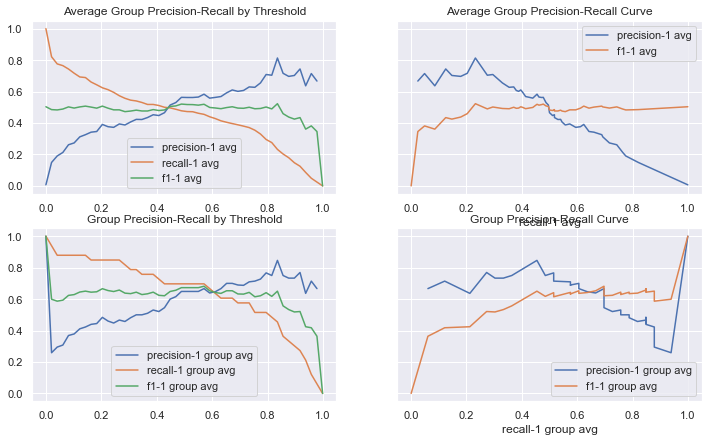

,precision,recall,f1-score,support
0.0,0.997225,0.997178,0.997201,63780.000000
1.0,0.597315,0.601351,0.599327,444.000000
accuracy,0.994441,0.994441,0.994441,0.994441
macro avg,0.797270,0.799265,0.798264,64224.000000
weighted avg,0.994460,0.994441,0.994451,64224.000000


Target groups: 33 



recall-1          0.474142
recall-1 group    0.696970
dtype: float64


Prediction groups: 37 



precision-1          0.562174
precision-1 group    0.648649
dtype: float64

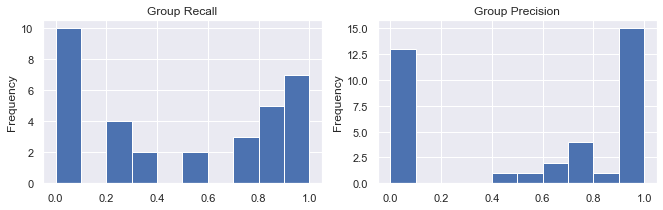

In [621]:
### Fit and predict with model pipeline
column_trans = ColumnTransformer([('scale', mms(), selected_columns)], remainder='drop')

# Pipeline
pipe = Pipeline([('scale', column_trans), ('under', rus), ('model', model)])

# Fit pipeline
pipe.fit(xt, yt)

# Predict Probability
yprob = predict_proba(pipe, xe)
# yprob = scale_proba(yprob, 0.5, limit=None)

### Prediction evaluation

### Evaluate prediction
ax = precision_recall_plot(ye, yprob)
ax, grp_curve = group_metrics.group_precision_recall_plot(ye, yprob, groups_eval, num=50)

### Selected threshold
sel_thresh = 0.5
yhat = (yprob > sel_thresh).astype('int')
groups_hat = groupConsecutiveFlags(ts=yhat)

scr = clf_score(ye, yprob, sel_thresh)
plt.show(); display(scr)
ax = group_metrics.group_precision_recall_stats(ye, yhat, groups_eval, groups_hat)

---
# 4. KFold cross-validation

In [622]:
scr_cols = np.array(['train_precision-1', 'train_recall-1', 'train_f1-1', 'test_precision-1', 'test_recall-1', 'test_f1-1'], dtype='object')
stats_cols = ['mean', 'std', 'min', '50%', 'max']

### Rebuild pipeline

In [623]:
rus = RandomUnderSampler(sampling_strategy=train_prct, random_state=seed)
column_trans = ColumnTransformer([('scale', mms(), non_constant)], remainder='drop')

# Pipeline
pipe = Pipeline([('scale', column_trans), ('under', rus), ('model', model)])

### Minority group kfold split - cross validation

In [624]:
splitter = MinorityGroupSplitUndersample(
    n_splits=5,
    # train_size=0.80, test_size=0.19,
    train_prct=None, test_prct='natural',
    random_state=seed,
)

cv_group = splitter.split(xt, yt, groups_train, strategy='GroupKFold')

# evaluate splits
scr_group =  pd.DataFrame(cross_validate(
    pipe, xt, yt, groups=groups_train,
    scoring=scoring, cv=cv_group,
    n_jobs=-1, verbose=5,
    return_train_score=True,
))

display(scr_group[scr_cols].describe().loc[['mean', 'std']])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.9s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.8s finished


,train_precision-1,train_recall-1,train_f1-1,test_precision-1,test_recall-1,test_f1-1
mean,0.826717,0.791088,0.807478,0.800728,0.598580,0.683428
std,0.039751,0.028647,0.010648,0.033614,0.058299,0.038172


---
# 5. Time series split cross-validation

### Time series based split pipeline

In [626]:
# n_splits = 10
fill_test = False

splitter = TimeSeriesSplit(n_splits, max_train_size=None, test_size=None)
cv_time = list(splitter.split(X, Y))

# Fill test folders
if fill_test:
    for i in range(n_splits):
        cv_time[i] = (cv_time[i][0], np.arange(cv_time[i][1].min(), len(X)))

### Cross-validation score

In [627]:
# evaluate splits
scr_time = pd.DataFrame(cross_validate(
    pipe, X, Y, # groups=groups_train,
    scoring=group_metrics.group_scorer, cv=cv_time,
    return_train_score=True,
    error_score=np.nan,
    n_jobs=-1, verbose=5,
    pre_dispatch='2*n_jobs',
))

# Reset score index by test start
test_start = []
for train, test in cv_time:
    test_start.append(X.iloc[test].index.min())
scr_time.index = test_start

# Test class proportion
mean_1 = pd.DataFrame(
    mms().fit_transform([[Y[cv[0]].mean(), Y[cv[1]].mean()] for cv in cv_time]),
    columns=['train_support-1 normalized', 'test_support-1 normalized'], index=scr_time.index
)
not_null = ~mean_1.iloc[:, 0].isin([0])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   30.6s finished


### Temporal performance

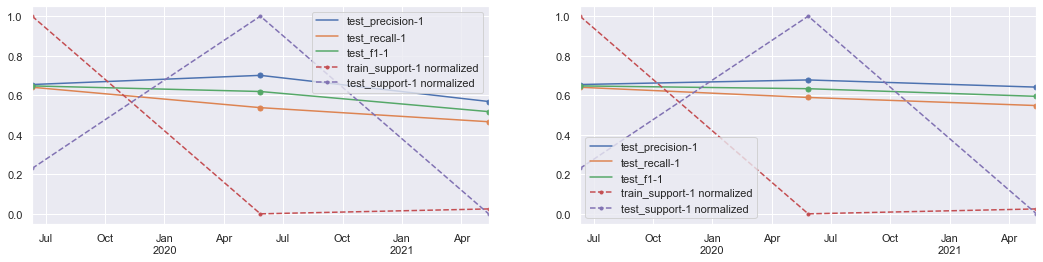

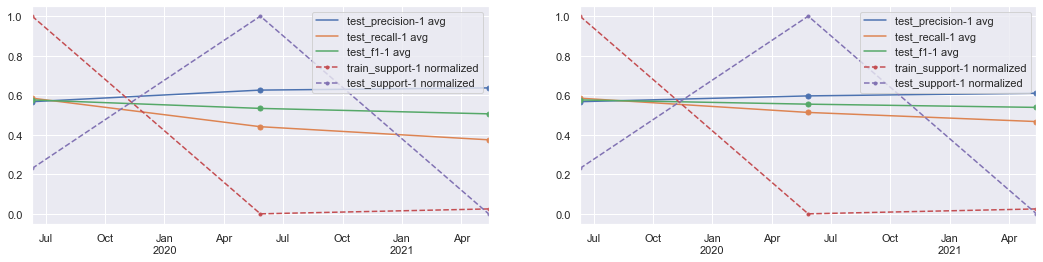

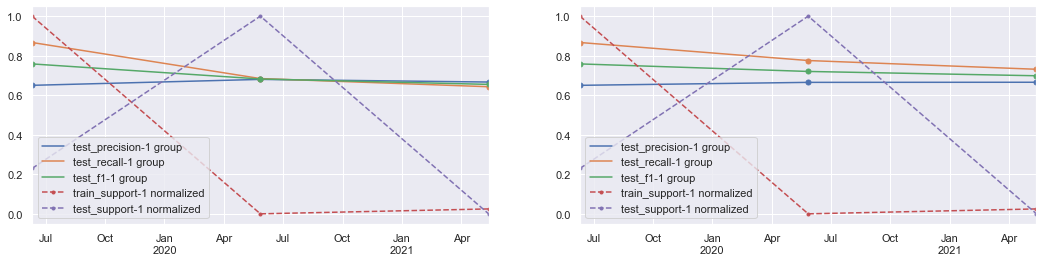

,train_precision-1,train_recall-1,train_f1-1,test_precision-1,test_recall-1,test_f1-1
mean,0.847067,0.766470,0.806769,0.640899,0.547718,0.594308
50%,0.845261,0.774725,0.815934,0.654054,0.537102,0.618782
std,0.009305,0.028794,0.017470,0.067114,0.087670,0.068427


,train_precision-1 avg,train_recall-1 avg,train_f1-1 avg,test_precision-1 avg,test_recall-1 avg,test_f1-1 avg
mean,0.654044,0.690627,0.672335,0.610069,0.466699,0.538384
50%,0.648821,0.685862,0.667342,0.625879,0.440713,0.533296
std,0.009668,0.032670,0.020928,0.037464,0.107678,0.035488


,train_precision-1 group,train_recall-1 group,train_f1-1 group,test_precision-1 group,test_recall-1 group,test_f1-1 group
mean,0.714054,0.900966,0.807510,0.665556,0.731245,0.698400
50%,0.714286,0.912281,0.802731,0.666667,0.684211,0.682105
std,0.020757,0.027545,0.018444,0.015031,0.119088,0.053674


In [628]:
for col_type in ['', ' avg', ' group']:
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    
    scr_time[scr_cols[3:6] + col_type].plot(marker='o', ms=5, ax=ax[0])
    mean_1.plot(linestyle='--', marker='.', ax=ax[0])

    scr_time[scr_cols[3:6] + col_type].rolling(100, min_periods=1).mean().plot(marker='o', ms=5, ax=ax[1])
    mean_1.plot(linestyle='--', marker='.', ax=ax[1])

    plt.show()

for col_type in ['', ' avg', ' group']:
    ### Average temporal performance
    display(scr_time.describe().loc[['mean', '50%', 'std'], scr_cols + col_type])

---
# Number of splits optimization

In [629]:
min_splits, max_splits, jump = 2, 10, 1
fill_test = True

scrs = []
n_splits_i = range(2, max_splits + 1, jump)
for n_splits in n_splits_i:
    co(wait=True); print(f'{n_splits}/{max_splits} splits evaluated')

    splitter = TimeSeriesSplit(n_splits, max_train_size=None, test_size=None)
    cv_time = list(splitter.split(X, Y))

    if fill_test: # Fill test folders
        for i in range(n_splits):
            cv_time[i] = (cv_time[i][0], np.arange(cv_time[i][1][0], len(X)))

    scr_time = pd.DataFrame(cross_validate(
        pipe, X, Y, # groups=groups_train,
        scoring=group_metrics.group_scorer, cv=cv_time,
        return_train_score=True,
        error_score=np.nan,
        n_jobs=-1, verbose=5,
        pre_dispatch='2*n_jobs',
    ))

    scr_time['n_splits'] = n_splits
    scrs.append(scr_time)

scrs = pd.concat(scrs)

10/10 splits evaluated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   28.5s remaining:   19.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   46.0s finished


### Average scores

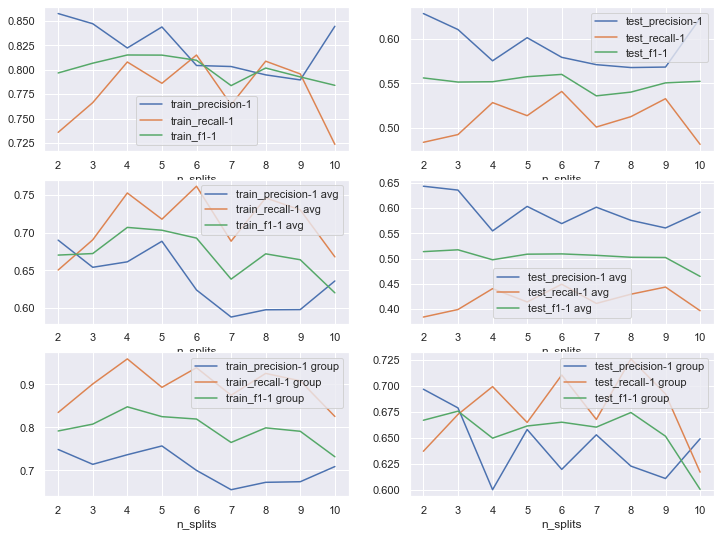

In [630]:
fig, ax = plt.subplots(3, 2, figsize=(12, 9))
for i, col_type in enumerate(['', ' avg', ' group']):
    for j, cols_index in enumerate([[0,1,2], [3,4,5]]):
        scrs.groupby('n_splits').mean()[scr_cols[cols_index] + col_type].plot(ax=ax[i][j])#, title='Time Series N° of Splits Optimization')

### Scores deviation

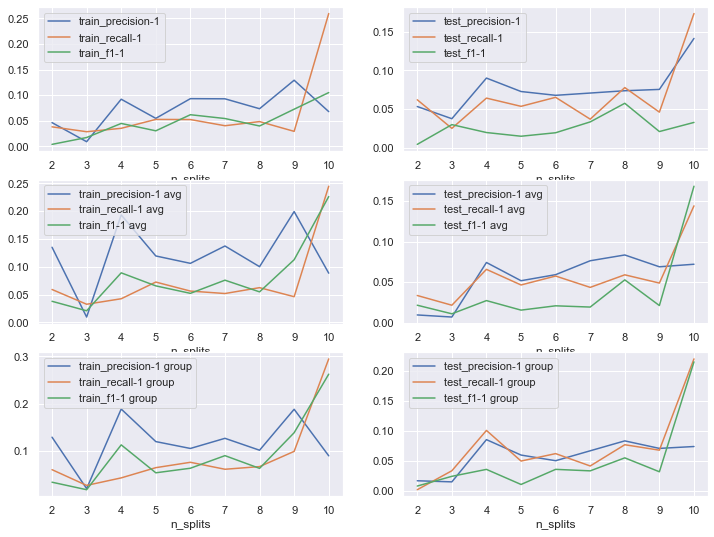

In [631]:
fig, ax = plt.subplots(3, 2, figsize=(12, 9))
for i, col_type in enumerate(['', ' avg', ' group']):
    for j, cols_index in enumerate([[0,1,2], [3,4,5]]):
        scrs.groupby('n_splits').std()[scr_cols[cols_index] + col_type].plot(ax=ax[i][j])#, title='Time Series N° of Splits Optimization')

---
# Concatenated splits' probabilities

### Time series based split

In [632]:
def cross_val_predict_proba(estimator, X, Y, cv, calibrate=None):
    yprob_cv, fail = [], []
    for i, (train, test) in enumerate(cv):
        try:
            estimator.fit(X.iloc[train], Y.iloc[train])
            yprob = predict_proba(estimator, X.iloc[test])
            # Optional scale probabilities
            if calibrate is not None:
                yprob = scale_proba(yprob, threshold=calibrate, limit=None)
            yprob_cv.append(yprob.values)
        except Exception as e:
            yprob_cv.append(np.array([np.nan] * len(test)))
            fail.append(e)
        co(True); print(f'cv: {i+1}/{len(cv)}')
    if len(fail): print('Errors:', fail)
    return yprob_cv

### Concatenated splits' probabilities

### Time series based split pipeline

In [633]:
from sklearn.model_selection import TimeSeriesSplit

n_splits = 3
splitter = TimeSeriesSplit(n_splits, max_train_size=None, test_size=None)
cv_time = list(splitter.split(X, Y))

# Fill test folders
# if fill_test:
#     for i in range(n_splits):
#         cv_time[i] = (cv_time[i][0], np.arange(cv_time[i][1][0], len(X)))

test_index = X.index[cv_time[0][1][0] :]

yprob_cv = cross_val_predict_proba(pipe, X, Y, cv_time, calibrate=None)
yprob = pd.Series(np.concatenate(yprob_cv), index=test_index)#.dropna()

yhat = (yprob > 0.5).astype('float')
groups_hat = groupConsecutiveFlags(ts=yhat)

ye = Y.loc[test_index]
groups_e = groups.loc[test_index]

ye_true = Y_true.loc[test_index]
groups_e_true = groups_true.loc[test_index]

cv: 3/3


### Probability time serie plot

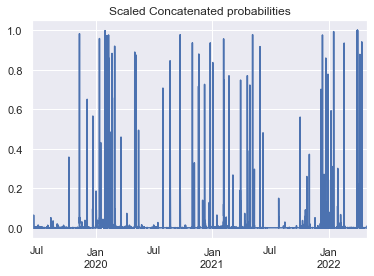

In [634]:
ax = yprob.plot(title='Scaled Concatenated probabilities')

### Whole period evaluation

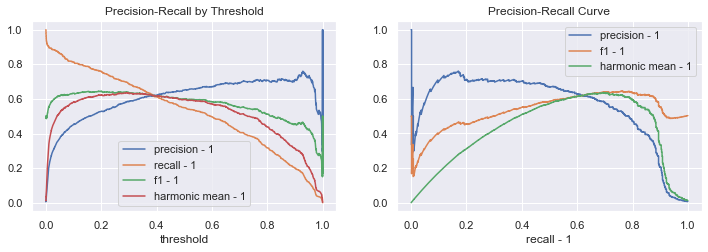

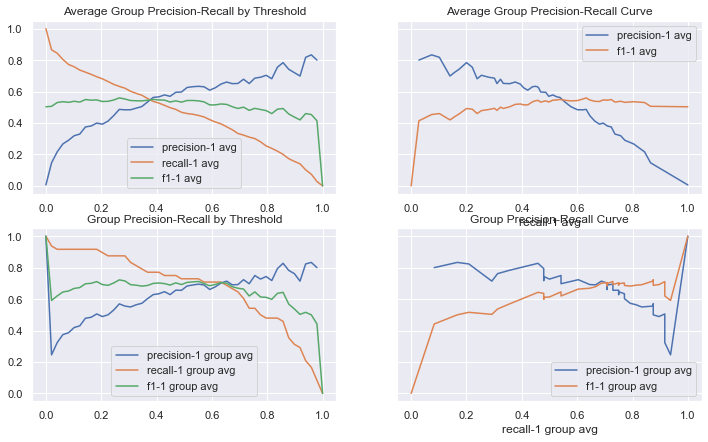

,precision,recall,f1-score,support
0.0,0.997158,0.998143,0.997650,100167.000000
1.0,0.651685,0.549763,0.596401,633.000000
accuracy,0.995327,0.995327,0.995327,0.995327
macro avg,0.824421,0.773953,0.797026,100800.000000
weighted avg,0.994988,0.995327,0.995130,100800.000000


Target groups: 48 



recall-1          0.466456
recall-1 group    0.729167
dtype: float64


Prediction groups: 60 



precision-1          0.609139
precision-1 group    0.666667
dtype: float64

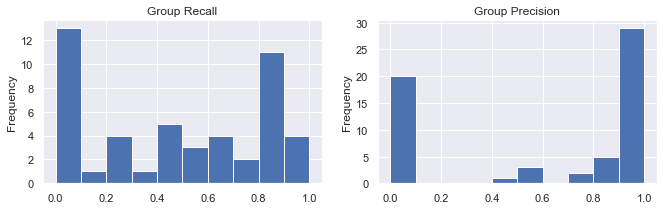

In [635]:
### Evaluate prediction
ax = precision_recall_plot(ye, yprob)
ax, grp_curve = group_metrics.group_precision_recall_plot(ye, yprob, groups_e, num=50)

### Selected threshold score
scr = clf_score(ye, yprob, 0.5)
plt.show(); display(scr)
ax = group_metrics.group_precision_recall_stats(ye, yhat, groups_e, groups_hat)

---
# Average identification time delay

In [656]:
def group_distances(ye, yhat, groups_e, groups_hat, unit='m'):

    groups_dist = []
    groups_hat_unique = groups_hat.unique()
    for i, group_hat in enumerate(groups_hat_unique):
        co(True); print(f'{i}/{len(groups_hat_unique) - 1}')
        if group_hat != -1:

            msk_grp_hat = groups_hat == group_hat
            ye_grp, yhat_grp = ye[msk_grp_hat], yhat[msk_grp_hat]
            start_hat, end_hat = yhat_grp.index[0], yhat_grp.index[-1]

            grps_e = groups_e[msk_grp_hat].unique()
            grps_e = grps_e[grps_e!=-1]; n_grps_e = len(grps_e)

            for group_e in grps_e:  # ignores code below if there's no true group intersecting the prediction group 'group_hat'.

                ye_grp_e = ye[groups_e == group_e]
                start_e, end_e = ye_grp_e.index[0], ye_grp_e.index[-1]

                dist_start = start_hat - start_e
                dist_end = end_hat - end_e

                groups_dist.append([group_hat, group_e, dist_start, dist_end, n_grps_e])
    
    groups_dist = pd.DataFrame(groups_dist, columns=['group_hat', 'group_e', 'dist_start', 'dist_end', 'n_groups_e'])                            
    if unit is not None:
        groups_dist[['dist_start', 'dist_end']] = groups_dist[['dist_start', 'dist_end']].astype(f'timedelta64[{unit}]')
    return groups_dist

def capture_report(n_capt, n_pred, n_true):

    prec = 100 * n_capt / n_pred
    rec = 100 * n_capt / n_true
    f1 = (prec + rec) / 2

    display(pd.DataFrame(
        [n_true, n_pred, n_capt, prec, rec, f1], columns=['Groups'],
        index=['true', 'predicted', 'captured', 'precision (%)', 'recall (%)', 'f1 (%)']
    ).round().astype('int')); print()

### Group based perdiction evaluation

In [657]:
unit = 'm'

delay = group_distances(ye_true, yhat, groups_e_true, groups_hat, unit=unit)
# delay = group_distances(ye, yhat, groups_e, groups_hat, unit=unit)
# Note: Must provide true target to measure prediction antecipation correctly

60/60


### Evaluation group statistics

In [658]:
n_true = groups_e_true.unique().shape[0] - 1
n_pred = groups_hat.unique().shape[0] - 1

n_capt = len(delay)
capture_report(n_capt, n_pred, n_true)

### Predicted before event
n_capt_before = len(delay[delay['dist_start']<=0])

print('Correct captured before:', round(100 * n_capt_before / n_capt, 1), '%')
capture_report(n_capt_before, n_pred, n_true)

,Groups
true,49
predicted,60
captured,38
precision (%),63
recall (%),78
f1 (%),70



Correct captured before: 71.1 %


,Groups
true,49
predicted,60
captured,27
precision (%),45
recall (%),55
f1 (%),50


### Prediction start delay distribution

In [708]:
edge = 'dist_start'
pred_dist = delay[edge].copy() - shift
time_bins = np.arange(pred_dist.min(), pred_dist.max(), freq)
dist_cnt = pred_dist.value_counts().reindex(time_bins, fill_value=0.0)

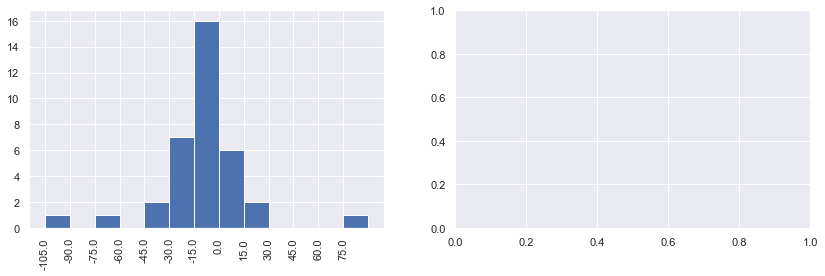

In [716]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
plt.show()

Average delay dist_start: -3.9  (minutes)

Average delay dist_end: -17.4  (minutes)



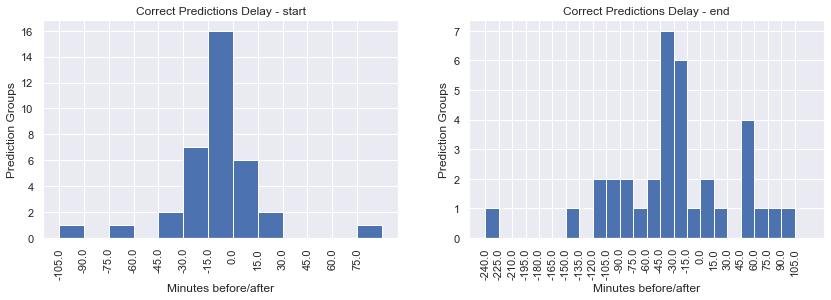

In [720]:
shift = 15
freq = 15

norm = 1 # len(delay)
norm_suffix = (' (%)' if norm != 1 else '')

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
for i, edge in enumerate(['dist_start', 'dist_end']):
    
    pred_dist = delay[edge].copy() - shift
    time_bins = np.arange(pred_dist.min(), pred_dist.max(), freq)
    dist_cnt = pred_dist.value_counts().reindex(time_bins, fill_value=0.0)
    
    ax[i].bar(time_bins, dist_cnt, width=15, align='edge')
    ax[i].set_xticklabels(time_bins, rotation=90)
    ax[i].set(
        title=f'Correct Predictions Delay - {edge.split("_")[-1]}',
        xlabel='Minutes before/after', ylabel='Prediction Groups' + norm_suffix,
        xticks=time_bins
    )
    print(f'Average delay {edge}:', round((pred_dist + shift/2).mean(), 1), ' (minutes)\n')
    
plt.show()

# Probability windows

#### Conclusions

##### Trends:
1. Not identified events
1. high probability in the middle of event
1. After start of event
1. Before start of event
1. After end of event

In [61]:
def groups_windows(groups, spread=6, freq=pd.Timedelta(1, 'h')):
    windows = []; wide = spread * freq
    for group in groups.unique():
        group_index = groups.index[groups==group]
        grp_min, grp_max = group_index.min(), group_index.max()
        windows.append((grp_min - wide, grp_max + wide))
    return windows

def window_prob(ye, yprob, time_lim, ax=None):
    yprob = pd.Series(mms().fit_transform(yprob.to_frame()).reshape(-1), index=yprob.index) # scale probability to 0-1 range
    msk = ye.index.to_series().between(*time_lim) # time window limits
    if ax is None: ax = plt.axes()
    yprob[msk].plot(ax=ax)
    ax = ye[msk].plot(ax=ax)
    return ax

def multi_window_prob(ye, yprob, windows, n_cols, title='Probability {} - {}', path=None):
    n_plots = len(windows)
    n_rows = int(n_plots / n_cols if n_plots % n_cols == 0 else n_plots // n_cols + 1)
    figsize = (6 * n_cols, 4 * n_rows)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, tight_layout=True, sharey=True)
    axs = list(axs.reshape(-1))
    i=0
    for ax, time_lim in zip(axs, windows):
        i+=1; co(wait=True); print(f'{i}/{len(windows)}')
        msk = ye.index.to_series().between(time_lim[0], time_lim[1]) # time window limits
        yprob[msk].plot(ax=ax)
        ye[msk].plot(ax=ax)
        time_min, time_max = (time_lim[j].strftime('%d-%h-%y %H:%m') for j in (0, 1))
        ax.set(title=title.format(time_min, time_max))
    if path is not None: plt.savefig(path)
    return fig, axs

### True and false positives

69/69


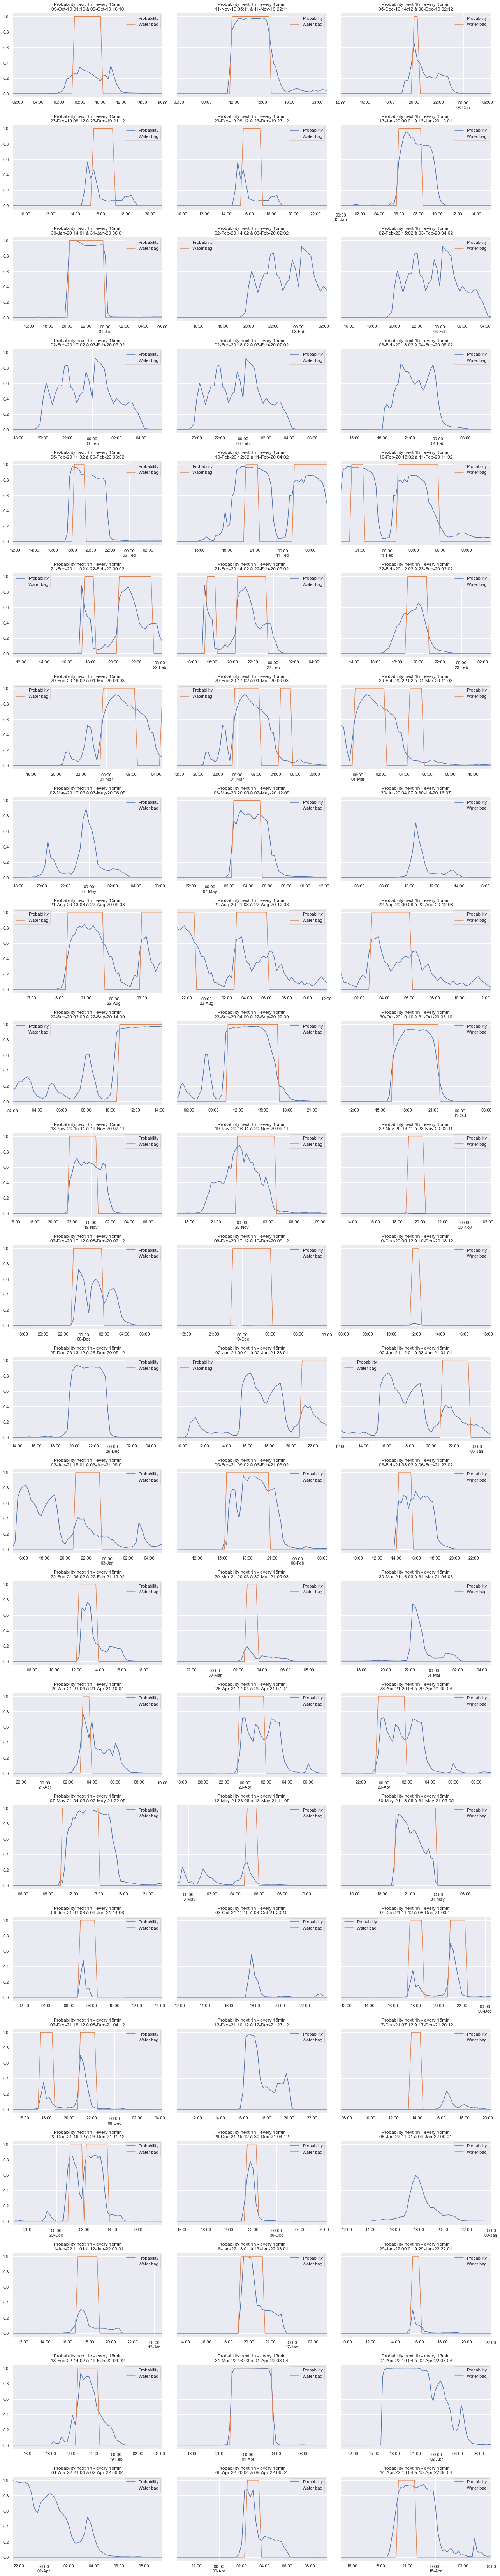

In [721]:
Y_positive = ((ye_true + yhat) > 0.0).astype('float')

groups_positive = groupConsecutiveFlags(Y_positive)

windows =  groups_windows(groups_positive[groups_positive!=-1], spread=6, freq=pd.Timedelta(1, 'h'))

n_cols = 3
title = 'Probability next 1h - every 15min\n{} à {}'
# path = 'Modelagem de Bolsões/Scores/Probabilidade Bolsões-Previsões.pdf'
path = None

fig, axs = multi_window_prob(
    ye_true.to_frame('Water bag'),
    yprob.to_frame('Probability'),
    windows, n_cols, title, path,
)